# **迁移学习与微调**

### **引入**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

### **介绍**

**迁移学习**是在一个任务上上学到的特征，并在新的类似问题上加以利用。例如，识别浣熊的模型中学习到的特征可能对识别狸猫的模型很有用。

迁移学习通常是针对数据集中数据太少而无法从头训练完整模型的任务设计的。

在深度学习中，迁移学习最常见的工作流程如下：

1. 从先前训练过的模型中获取层
2. 冻结它们，以免在随后的训练中破坏它们所包含的信息
3. 在冻结层的顶部添加一些新的可训练层，它们将学习利用旧特征转变为对新数据集的预测
4. 在数据集上训练新层。

最后一个可选步骤是**微调**，包括将原先获得的整个模型（或模型的一部分）解除冻结，然后以非常低的学习率对新数据进行重新训练，通过将预训练的特征逐步适应新数据，可以实现有意义的改进。

首先，我们将详细介绍Keras `trainable` API，它是大多数迁移学习和微调工作流的基础。

然后，我们利用在ImageNet数据集上预训练的模型，在Kaggle的“猫与狗”分类数据集中对其进行重新训练，以此来演示典型的工作流程。

这些内容改编自[Python深度学习](https://www.manning.com/books/deep-learning-with-python)和2016年博客文章“[使用很少的数据构建强大的图像分类模型](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)” 。

### **冻结层：了解trainable属性**

层和模型具有三个权重属性：

+ `weights`是该层的所有权重变量的列表
+ `trainable_weights`是一个训练过程中，通过更新（梯度下降）以达到最小损失的权重列表。
+ `non_trainable_weights`是不用于训练的权重列表。通常，它们在前向传递期间由模型更新。

示例：`Dense`层具有2个可训练的权重（内核和偏差）

In [2]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # 创建一个权重

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


通常，所有权重都是可训练的权重，唯一具有不可训练权重的内置层是`BatchNormalization`层，它使用不可训练的权重来跟踪训练期间其输入的均值和方差。要了解如何在自己的自定义层中使用不可训练的权重，请参阅[从头开始编写新层的指南](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing)。

**示例：`BatchNormalization`层具有2个可训练的权重和2个不可训练的权重**

In [3]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # 创建一个权重

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


层和模型还具有`trainable`的布尔属性，其值可以更改。将`layer.trainable`设置为`False`会将层的所有权重从可训练变为不可训练，这个操作称为“冻结”层：冻结层的状态在训练期间不会更新（无论是使用`fit()`进行训练，还是使用依赖于`trainable_weights`来应用梯度更新的自定义循环）。

**示例：将`trainable`设置为`False`**

In [4]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # 创建一个权重
layer.trainable = False  # 冻结层

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


当可训练的权重变得不可训练时，其值将在训练期间不再更新。

In [5]:
# 创建一个具有两个层的模型
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# 冻结第一层
layer1.trainable = False

# 保留layer1的权重副本以供以后参考
initial_layer1_weights_values = layer1.get_weights()

# 训练模型
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# 检查训练期间layer1的权重是否保持不变
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - 0s 2ms/step - loss: 0.0577


不要将`layer.trainable`属性与`layer.__call__()`的`training`参数混淆（该参数控制该层是应该以预测模式还是训练模式运行其前向传递）。有关更多信息，请参见[Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)。

### **trainable属性的递归设置**

如果在模型或具有子层的层上设置`trainable = False`，则所有子层也将变为不可训练。

**示例：**

In [6]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # 冻结外部模型

assert inner_model.trainable == False  # 在`model`中的所有层都被冻结
assert inner_model.layers[0].trainable == False  # `trainable`是递归传播的

### **典型的迁移学习工作流程**

下面内容使我们了解如何在Keras中实现典型的迁移学习工作流程：

1. 实例化基本模型并将预训练的权重加载到其中。
2. 通过设置`trainable = False`冻结基本模型中的所有层。
3. 在基础模型的一层（或几层）的输出之上创建一个新模型。
4. 在新数据集上训练新模型。

请注意，另一种更轻量的工作流程如下：

1. 实例化基本模型并将预训练的权重加载到其中。
2. 通过它运行新的数据集，并记录基础模型中一层（或几层）的输出。这称为**特征提取**。
3. 使用该输出作为新的模型的输入数据。

第二个工作流程的一个关键优势在于，你只需使用基本模型运行一次数据即可，而不是每次训练一次，因此，它更快，代价更低。

但是，第二个工作流程的问题是，它不允许你在训练期间动态修改新模型的输入数据，在进行数据扩充时，这是必需的。迁移学习通常用于当新数据集的数据太少而无法从头训练完整模型的任务，在这种情况下，数据扩充非常重要。因此，在接下来的内容中，我们将专注于第一个工作流程。

下面是Keras中第一个工作流程的示例：

首先，使用实例化预训练的基本模型。

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # 加载ImageNet上的预训练权重
    input_shape=(150, 150, 3),
    include_top=False)  # 不在顶部包括ImageNet分类器

83689472/83683744 [==============================] - 1s 0us/step


然后，冻结基本模型。

In [8]:
base_model.trainable = False

在顶部创建一个新模型。

In [9]:
inputs = keras.Input(shape=(150, 150, 3))
# 我们通过传递`training = False`确保base_model在此以预测模式运行。
# 这对于微调非常重要。
x = base_model(inputs, training=False)
# 将形状为`base_model.output_shape [1：]`的特征转换为矢量
x = keras.layers.GlobalAveragePooling2D()(x)
# 具有一个单位的密度分类器（二进制分类）
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

在新数据上训练模型。

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

### **微调**

一旦你的模型在新数据上收敛，你就可以尝试解冻全部或部分基本模型，并以非常低的学习率来端到端地重新训练整个模型。

这是最后一个可选步骤，可以为你提供增量式改进。它还可能导致快速过拟合--请记住这一点。

至关重要的是，只有在训练具有冻结层的模型且使其训练收敛才执行此步骤。如果将随机初始化的可训练层与包含预训练特征的可训练层混合使用，则随机初始化的层将在训练过程中引起较大的梯度更新，这将破坏你的预训练特征。

在此阶段使用非常低的学习率也很关键，因为在很小的数据集上，你训练的模型比第一轮训练中的模型大得多。因此，如果你应用较大的权重更新，则可能会很快地过拟合。在这里，你只想增量式地重新调整预训练的权重。

这是实现整个基本模型的微调的方法：

In [ ]:
# 解冻基本模型
base_model.trainable = True

# 在对内层的“trainable”属性进行
# 更改之后，重新编译模型非常重要，这样才能将更改应用
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # 非常低的学习率
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# 端到端训练。在过拟合之前及时停止
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

#### **关于`compile()`和`trainable`重要说明**

在模型上调用`compile()`旨在“冻结”该模型的行为。这意味着在编译模型时，应该在该模型的整个生命周期中保留`trainable`属性值，直到再次调用`compile`为止。因此，如果你更改了`trainable`值，请确保再次在模型上调用`compile()`，以应用你的更改。

#### **有关`BatchNormalization`层的重要说明**

许多图像模型包含`BatchNormalization`层。在每一个可以想象的数量上，该层都是一个特例，这里有几件事要牢记。

+ `BatchNormalization`包含2个不可训练的权重，它们在训练过程中会更新，它们是跟踪输入的均值和方差的变量。
+ 当设置`bn_layer.trainable = False`，`BatchNormalization`层将以预测模式运行，并且不会更新其均值和方差的统计信息。通常对于其他层来说并不是如此，因为权重的可训练性和预测/训练模式是两个正交的概念，但是在`BatchNormalization`层中，两者是并列的。
+ 当你解冻包含`BatchNormalization`层的模型以进行微调时，应在调用基本模型时通过传递`training=False`来使`BatchNormalization`层保持预测模式。否则，应用于不可训练权重的更新将会破坏模型学习到的模型。

你将在本指南结尾处的端到端示例中看到这种模式。

### **通过自定义训练循环进行迁移学习和微调**

如果你不是使用`fit()`，而是使用自己的低级别训练循环，则工作流程基本上保持不变。在应用梯度更新时，你应注意仅考虑`model.trainable_weights`列表：

In [ ]:
# 创建一个基本模型
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# 冻结基本模型
base_model.trainable = False

# 在顶层创建一个新模型
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# 遍历数据集的批次
for inputs, targets in new_dataset:
    # 打开一个GradientTape.
    with tf.GradientTape() as tape:
        # 前向传递
        predictions = model(inputs)
        # 计算该批次的损失值
        loss_value = loss_fn(targets, predictions)

    # 通过*可训练的*权重获得损失的梯度
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # 更新模型权重
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

同样可以进行前面的微调操作

### **一个端到端的示例：微调猫和狗的图像分类模型**

数据集

为了巩固这些概念，让我们为你介绍一个具体的端到端迁移学习和微调示例。我们将加载在ImageNet上预先训练的Xception模型，并将其用于Kaggle“猫与狗”分类数据集中。

#### **获取数据**
首先，让我们使用TFDS获取“猫狗”数据集。如果你有自己的数据集，则可能要使用接口[`tf.keras.preprocessing.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)从磁盘上已归类好的图像文件夹中，生成相似的标记数据集对象。

当处理非常小的数据时，迁移学习最为有用。为了使我们的数据集较小，我们将使用原始训练数据的40％（25,000张图像）进行训练，将10％用于验证，将10％用于测试。

In [10]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 10%数据用于验证，10%数据用于测试
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # 包括标签
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete3HMQ08/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: -2
Number of validation samples: -2
Number of test samples: -2


这些是训练数据集中的前9张图像--如你所见，它们都是不同的大小。

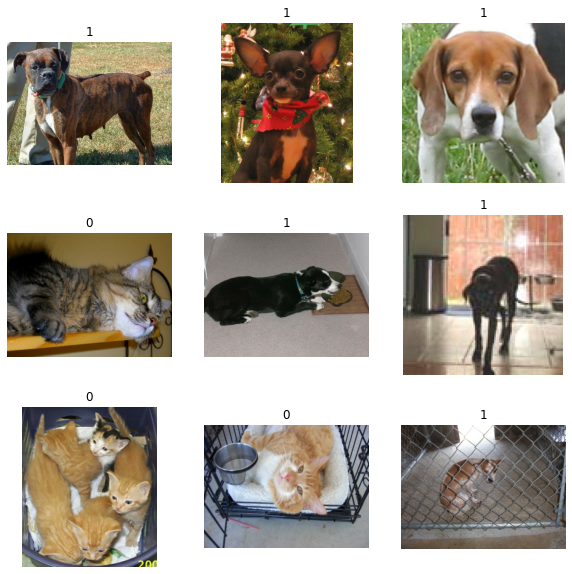

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

在上面的图中，我们可以看到标签1是“dog”，标签0是“cat”。

#### **标准化数据**
我们的原始图像有各种尺寸，另外，每个像素由0到255之间的3个整数值（RGB级别值）组成，这不太适合用于神经网络，所以我们需要做两件事：

+ 标准化为固定的图像尺寸，我们选择150x150。
+ 归一化介于-1和1之间的像素值，我们将使用`Normalization`层作为模型本身的一部分来进行此操作。

通常，与采用已预处理数据的模型相反，开发以原始数据为输入的模型是一个更佳的实践。原因是，如果模型需要预处理的数据，则每次在其他地方使用导出的模型（在Web浏览器，移动应用程序中）时，都需要重新实现完全相同的预处理管道，这会变得非常棘手。因此，在达到模型之前，我们应该进行尽可能少的预处理。

在这里，我们将在数据管道中进行图像大小调整（因为深度神经网络只能处理连续的数据批次），并且在创建模型时将其作为模型的一部分进行输入值缩放。

让我们将图像调整为150x150：

In [12]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

此外，让我们分批处理数据并使用缓存和预取来优化加载速度。

In [13]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

#### **使用随机数据扩充**

当你的图像数据集不够大时，有一种很好的做法是，通过对训练图像应用随机且逼真的变换（例如随机水平翻转或小的随机旋转）来人为引入样本多样性。这有助于模型学习到训练数据的不同方面，同时减慢过拟合的速度。

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

让我们直观地来看一下经过各种随机转换后的第一批图像：

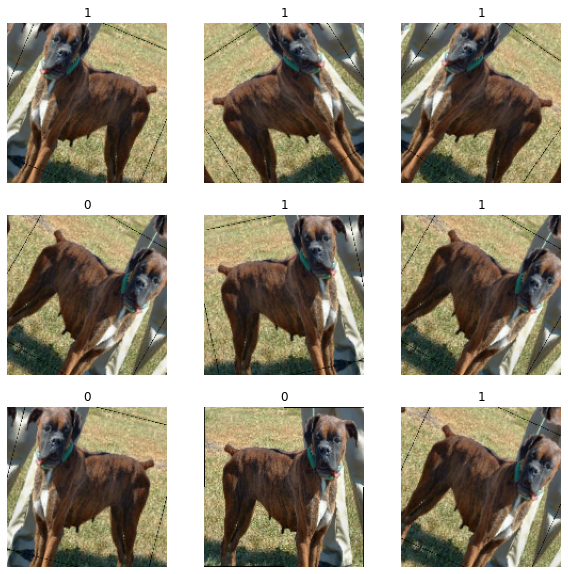

In [15]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

#### **创建模型**

现在让我们创建一个遵循先前逻辑的模型。

注意：

+ 我们使用`Normalization`层将输入值（最初在`[0, 255]`范围内）缩放到`[-1, 1]`范围。
+ 我们在分类层之前添加一个`Dropout`层，以进行正则化。
+ 我们确保在调用基本模型时传递`training=False`，以便它在预测模式下运行，使得即使我们取消冻结基本模型进行微调后，batchnorm统计信息也不会得到更新。

In [16]:
base_model = keras.applications.Xception(
    weights="imagenet",  # 加载在ImageNet上预先训练的权重
    input_shape=(150, 150, 3),
    include_top=False,
)  # 不要在顶部包含ImageNet分类器

# 冻结base_model
base_model.trainable = False

# 在顶层创建新模型
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # 应用随机数据扩充

# 预先训练的Xception权重要求将输入从（0，255）归一化为范围（-1.，+1.），归一
# 化层执行以下操作，输出=（输入-平均值）/ sqrt（var）
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# 将输入缩放到[-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# 基本模型包含batchnorm层。 当我们解冻基本模型以进行微调时，我们希望
# 将它们保持在预测模式下，因此我们确保此处的base_model在预测模式下运行。
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # 使用dropout正则化
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

#### 训练顶层

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 18s 63ms/step - loss: 0.1664 - binary_accuracy: 0.9262 - val_loss: 0.0890 - val_binary_accuracy: 0.9690
Epoch 2/20
291/291 [==============================] - 15s 52ms/step - loss: 0.1202 - binary_accuracy: 0.9499 - val_loss: 0.0851 - val_binary_accuracy: 0.9699
Epoch 3/20
291/291 [==============================] - 15s 52ms/step - loss: 0.1131 - binary_accuracy: 0.9536 - val_loss: 0.0853 - val_binary_accuracy: 0.9682
Epoch 4/20
291/291 [==============================] - 15s 52ms/step - loss: 0.1104 - binary_accuracy: 0.9555 - val_loss: 0.0776 - val_binary_accuracy: 0.9690
Epoch 5/20
291/291 [==============================] - 15s 52ms/step - loss: 0.1052 - binary_accuracy: 0.9587 - val_loss: 0.0763 - val_binary_accuracy: 0.9682
Epoch 6/20
291/291 [==============================] - 15s 52ms/step - loss: 0.1051 - binary_accuracy: 0.9546 - val_loss: 0.0746 - val_binary_accuracy: 0.9712
Epoch 7/20
291/291 [==============================] 

#### **对整个模型进行一轮微调**

最后，让我们解冻基本模型，并以较低的学习率端到端地训练整个模型。

重要的是，尽管基本模型变得可训练，但由于我们在构建模型时调用该模型时传递了`training=False`，因此它仍以预测模式运行。这意味着内部的批量规范化层不会更新其批量统计信息，因为如果会更新的话，它们将破坏迄今为止该模型所学习的表示形式。

In [18]:
# 解冻base_model。注意，自从我们在调用它时传递了“training = False”以
# 来，它一直在预测模式下运行。 这意味着batchnorm层将不会更新其批次统计信
# 息。这可以防止batchnorm层破坏到目前为止我们已经完成的所有训练
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # 低学习率
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

291/291 [==============================] - 62s 213ms/step - loss: 0.0761 - binary_accuracy: 0.9697 - val_loss: 0.0576 - val_binary_accuracy: 0.9781
Epoch 2/10
291/291 [==============================] - 61s 211ms/step - loss: 0.0527 - binary_accuracy: 0.9799 - val_loss: 0.0472 - val_binary_accuracy: 0.9832
Epoch 3/10
291/291 [==============================] - 61s 210ms/step - loss: 0.0392 - binary_accuracy: 0.9862 - val_loss: 0.0515 - val_binary_accuracy: 0.9798
Epoch 4/10
291/291 [==============================] - 61s 210ms/step - loss: 0.0374 - binary_accuracy: 0.9855 - val_loss: 0.0511 - val_binary_accuracy: 0.9802
Epoch 5/10
291/291 [==============================] - 61s 210ms/step - loss: 0.0294 - binary_accuracy: 0.9884 - val_loss: 0.0460 - val_binary_accuracy: 0.9807
Epoch 6/10
291/291 [==============================] - 61s 210ms/step - loss: 0.0266 - binary_accuracy: 0.9905 - val_loss: 0.0443 - val_binary_accuracy: 0.9832
Epoch 7/10
291/291 [==============================] - 61s

经过10个epoch后，微调在这里取得了很大的提升。